# Make your own neural network

Create a multi-layer perceptron neural network model to predict on a labeled dataset of your choosing. Compare this model to either a boosted tree or a random forest model and describe the relative tradeoffs between complexity and accuracy. Be sure to vary the hyperparameters of your MLP!

For this assignment, the figure skating data from my Unit 3 Capstone will be re-used. 

## Data inspection/cleaning

In [1]:
# load and inspect data
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
path=r"/Users/kyleknoebel/Desktop/ThinkfulNotebooks/Unit 3 Capstone/performances_judged.csv"
pj=pd.read_csv(path)
# replace all null values with 0
pj=pj.fillna(0)
pj.describe()

,rank,starting_number,total_segment_score,total_element_score,total_component_score,total_deductions,aspect_num,base_value,factor,goe,ref,scores_of_panel
count,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.000000,23932.0,23932.000000
mean,7.883169,7.929550,99.361830,50.394217,49.395199,0.427586,3.431765,3.143990,0.438743,0.278006,0.0,6.147335
std,6.525922,6.548071,37.110716,18.879934,18.907632,0.751289,3.641213,3.167566,0.639486,0.834628,0.0,2.536225
min,1.000000,1.000000,24.550000,8.750000,15.800000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.0,0.000000
25%,3.000000,3.000000,68.250000,35.570000,32.650000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.070000
50%,6.000000,6.000000,93.480000,46.970000,46.420000,0.000000,2.000000,3.000000,0.000000,0.000000,0.0,6.300000
75%,10.000000,10.000000,126.510000,62.600000,64.410000,1.000000,6.000000,5.000000,0.800000,0.710000,0.0,7.860000
max,37.000000,37.000000,223.200000,126.120000,97.080000,9.000000,14.000000,17.900000,2.000000,3.300000,0.0,20.330000


In [2]:
# show the listing of columns with proper indexing
for index, value in enumerate(pj, 1):
    print("{}. {}".format((index-1), value))

0. performance_id
1. competition
2. competition1
3. name
4. nation
5. rank
6. starting_number
7. total_segment_score
8. total_element_score
9. total_component_score
10. total_deductions
11. aspect_id
12. performance_id-2
13. section
14. aspect_num
15. aspect_desc
16. info_flag
17. credit_flag
18. base_value
19. factor
20. goe
21. ref
22. scores_of_panel


### Clean the data and create data frames for elements and components

First, the dataset will be cleaned for better formatting/slicing.

In [3]:
# lower the capilization of the program and competition1 columns to standardize formatting
pj.iloc[:, 2] = pj.iloc[:, 2].str.lower()
pj.iloc[:, 1] = pj.iloc[:, 1].str.lower()
# clean the text for interpretations
pj.iloc[:, 15]=pj.iloc[:, 15].str.replace('Interpretation of the Music / Timing', 
                                                        'Interpretation of the Music')
pj.iloc[:, 15]=pj.iloc[:, 15].str.replace('Interpretation of the Music/Timing', 
                                                        'Interpretation of the Music')
# remove ice dancing from the dataset
pj=pj[~pj['competition1'].str.contains('ice dance')]
#remove short program from the dataset
pj=pj[~pj['competition1'].str.contains('short')]

Then a column for the type of element will be added called 'elem_type.' Types of elements will be discussed later in the report, and a list of abbreviations can be found in Appendix A.  

In [4]:
# add element type for each technical element
pj.loc[pj['aspect_desc'].str.contains('Sp'), 'elem_type']='spin'
pj.loc[pj['aspect_desc'].str.contains('Sq'), 'elem_type']='step'
pj.loc[pj['aspect_desc'].str.contains('Th'), 'elem_type']='throw jump'
pj.loc[pj['aspect_desc'].str.contains('Tw'), 'elem_type']='twist lift'
pj.loc[pj['aspect_desc'].str.contains('Li'), 'elem_type']='lift'
pj.loc[pj['aspect_desc'].str.contains('Ds' or 'Pi'), 'elem_type']='death spirals'
pj.loc[pj['aspect_desc'].str.contains('PsP' or 'PCoSp'), 'elem_type']='pair spins'
# the remaining rows with NaN in the elem_type column are either jumps or components
## since all jumps have a number in the aspect_desc and components do not, the jumps will be selected for using:
pj.loc[pj['aspect_desc'].str.contains('(\d+)') & (pj['elem_type'].isnull()), 'elem_type']='jump'

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  # This is added back by InteractiveShellApp.init_path()


Next, create separate dataframes for components and elements, and also create a separate dataste for the pairs competition since the elements in pairs skating differ from the singles categories. 

In [5]:
# create separate dataframe for ladies competition
# find the rows that contain 'ladies' in the name of each program category in the data frame 
ladies=pj[pj.iloc[:, 2].str.contains('ladies' , regex=False, case=False, na=False)]

# create separate dataframes for components and elements
elems=ladies[ladies['section']=='elements']
compos=ladies[ladies['section']=='components']

# create a data frame for the components of the ladies
ladies_compo=ladies[ladies.iloc[:, 13].str.contains('components', regex=False, case=False, na=False)]
# create a data frame for the elements of the ladies
ladies_elem=ladies[ladies.iloc[:, 13].str.contains('elements', regex=False, case=False, na=False)]

The aspect_desc for the components will be converted to a categorical variable for modelling. 

In [6]:
# recategorize the object columns as category
compos_model=ladies_compo.copy()
compos_model = pd.concat([
        compos.select_dtypes([], ['object']),
       compos.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(compos.columns, axis=1)
# create categorical values
objs=compos_model[['aspect_desc']]
objs= objs.apply(lambda x: x.cat.codes)
objs=objs.rename(columns={"aspect_desc": "aspect_cat"})
# drop string values and add categorical values
compos_model=pd.concat([compos_model, objs], 1)

## Data engineering

### Create data table

In order to properly train the model, the data will be organized to show the selected data for each performance. Since the hypothesis posits that the attributes of an element score affect the component score, the base values, GOE's, and deductions of the element portion will be selected. 

Since the GOE shown in the data is the averaged value, a new GOE will be calculated by dividing the GOE by the base value to show the true GOE value awarded when the element is performed. Total deductions will also be removed now and added to the final model dataframe as the deduction in each line is the total number of deductions for the performance.  

In [7]:
# create a dataframe with only variables of interest and show format
df_model = ladies_elem.drop(['competition', 'competition1', 'name', 'nation', 'rank', 'starting_number', 
                         'total_segment_score', 'total_element_score', 'total_component_score', 'aspect_id',
                        'performance_id-2', 'section', 'factor', 'aspect_num', 'aspect_desc', 'info_flag', 
                             'credit_flag', 'ref', 'scores_of_panel', 'elem_type'], 1)
# create actual GOE value and remove old value
df_model['goe_actual']=df_model['goe']/df_model['base_value']
df_model.head()

,performance_id,total_deductions,base_value,goe,goe_actual
10,e37083608d,0.0,3.63,0.14,0.038567
21,1b967c18c5,0.0,3.50,0.07,0.020000
26,2adfc0ee61,0.0,3.63,0.71,0.195592
32,64a3a7349a,0.0,2.70,1.00,0.370370
39,3c12ecb0ee,0.0,7.26,0.50,0.068871


In order to organize the data for each performance, a rank column will be added to the elements for each performance id. This rank will then be used to sort the elements from highest to lowest base value, while keeping the element attributes (base value, goe, element category) in the same corresponding pattern. This means the highest base value score will be first, while it's corresponding GOE will be first among that category. This will add logic to the table that will ensure the GBM model is accurate. 

In addition, the total deductions shown in each row of the data is the total number of deductions in the performance. As such, the total deductions will be removed from the data and appended at the end of the engineering process.  

In [8]:
# add a rank column to rank the base values by performance id
df_model["rank"] = df_model.groupby("performance_id")["base_value"].rank("dense", ascending=False)
df_model=df_model.reset_index()
# sort the values by this ranking
df_model=df_model.sort_values('rank')
df_model.head()

,index,performance_id,total_deductions,base_value,goe,goe_actual,rank
2416,21048,059039bcf6,0.0,11.22,0.6,0.053476,1.0
1063,9525,c351343d7d,0.0,8.30,-0.4,-0.048193,1.0
747,6647,7d9640cf7e,1.0,9.60,1.3,0.135417,1.0
296,2667,8712edfbc0,0.0,8.20,0.8,0.097561,1.0
294,2658,265a603120,0.0,11.33,-0.5,-0.044131,1.0


In [9]:
# create separate data frame for deductions
df_deduc=df_model.copy()
df_deduc=df_deduc.drop(['base_value', 'goe', 'goe_actual', 'rank'], 1)
# drop duplicate performances
df_deduc['performance_id']=df_deduc['performance_id'].drop_duplicates()
df_deduc=df_deduc.dropna()
df_deduc.head()

,index,performance_id,total_deductions
2416,21048,059039bcf6,0.0
1063,9525,c351343d7d,0.0
747,6647,7d9640cf7e,1.0
296,2667,8712edfbc0,0.0
294,2658,265a603120,0.0


In [10]:
# create a pivot table showing the base value, goe, and deductions for each performance
df_model=pd.pivot_table(df_model, index=['performance_id'], columns=df_model.groupby(['performance_id']).cumcount().add(1), 
                  values=['base_value','goe_actual', 'rank'], aggfunc='sum')
# relabel columns with proper titles
df_model.columns=df_model.columns.map('{0[0]}{0[1]}'.format) 
# reset index for modeling
df_model=df_model.reset_index()
# drop the ranks columns, they are not needed for model
df_model=df_model.drop(['rank1', 'rank2', 'rank3', 'rank4', 'rank5', 'rank6', 'rank7', 'rank8', 'rank9', 'rank10',
                       'rank11', 'rank12'], 1)
# add the deduction column 
df_model=df_model.merge(df_deduc, how='left', on=['performance_id'])
df_model.head()

,performance_id,base_value1,base_value2,base_value3,base_value4,base_value5,base_value6,base_value7,base_value8,base_value9,...,goe_actual5,goe_actual6,goe_actual7,goe_actual8,goe_actual9,goe_actual10,goe_actual11,goe_actual12,index,total_deductions
0,010e399739,9.46,8.60,6.00,5.61,4.84,3.70,3.63,3.5,3.30,...,-0.330579,-0.486486,0.195592,0.225714,0.193939,0.156250,0.190000,0.650000,14650,0.0
1,018b293978,10.30,8.36,5.61,5.30,4.84,3.90,3.50,3.3,3.00,...,0.144628,0.282051,0.182857,0.151515,0.190000,0.166667,0.400000,-0.318182,18582,0.0
2,01b0b01f6f,8.25,6.60,6.00,5.54,5.10,3.63,3.30,3.2,3.00,...,0.000000,0.000000,0.151515,0.134375,0.070000,0.208333,0.100000,-0.181818,340,0.0
3,01e5ba3b8e,8.60,8.20,6.00,5.83,5.61,5.06,4.62,3.2,3.00,...,0.089127,0.057312,-0.454545,0.246875,0.010000,0.165385,0.029167,0.450000,18815,2.0
4,0375e990b4,11.99,9.60,6.00,5.61,3.63,3.63,3.50,3.0,2.77,...,0.019284,0.079890,0.162857,0.166667,-0.758123,0.022222,0.384615,0.500000,16178,1.0


### Create target table

The target table will be the total component score of each performance. The process below will show the scores of each component per performance, but this data is only shown in case it is necessary for future analysis. The individual scores will not be used in the model.

In [11]:
# only keep variables of interest for modeling
df_target=compos_model.drop(['competition', 'competition1', 'name', 'nation', 'rank', 'starting_number', 
                             'total_segment_score', 'total_element_score', 'total_deductions', 'aspect_id', 
                             'performance_id-2', 'section', 'aspect_num', 'info_flag', 
                             'credit_flag', 'base_value', 'factor', 'goe', 'ref', 'elem_type', 'aspect_desc',
                            'total_component_score'], 
                            1)
# create pivot table of values
df_target=pd.pivot_table(df_target, index=["performance_id"], columns=['aspect_cat'],
                         values=(['scores_of_panel']), aggfunc='sum')
# add total column to target table
df_target['total_score']=df_target.sum(axis=1)
# multiply by 2 to account for the factor 
df_target['total_score']=df_target['total_score']*2
# reset index
df_target=df_target.reindex()
df_target.head()

scores_of_panel                         total_score
aspect_cat                   0     1     2     3     4            
performance_id                                                    
010e399739                8.21  8.14  8.18  8.29  7.89       81.42
018b293978                7.82  7.82  7.82  8.11  7.54       78.22
01b0b01f6f                6.07  6.18  6.07  6.21  5.75       60.56
01e5ba3b8e                7.68  7.75  7.68  7.82  7.39       76.64
0375e990b4                8.36  8.43  8.25  8.46  8.21       83.42

Then the total score is added to the end of the model dataframe to create one model dataframe. 

In [12]:
# add the total score column from the target table to the model table
df_model=df_model.merge(df_target['total_score'], how='left', on=['performance_id'])
df_model.head()

,performance_id,base_value1,base_value2,base_value3,base_value4,base_value5,base_value6,base_value7,base_value8,base_value9,...,goe_actual6,goe_actual7,goe_actual8,goe_actual9,goe_actual10,goe_actual11,goe_actual12,index,total_deductions,total_score
0,010e399739,9.46,8.60,6.00,5.61,4.84,3.70,3.63,3.5,3.30,...,-0.486486,0.195592,0.225714,0.193939,0.156250,0.190000,0.650000,14650,0.0,81.42
1,018b293978,10.30,8.36,5.61,5.30,4.84,3.90,3.50,3.3,3.00,...,0.282051,0.182857,0.151515,0.190000,0.166667,0.400000,-0.318182,18582,0.0,78.22
2,01b0b01f6f,8.25,6.60,6.00,5.54,5.10,3.63,3.30,3.2,3.00,...,0.000000,0.151515,0.134375,0.070000,0.208333,0.100000,-0.181818,340,0.0,60.56
3,01e5ba3b8e,8.60,8.20,6.00,5.83,5.61,5.06,4.62,3.2,3.00,...,0.057312,-0.454545,0.246875,0.010000,0.165385,0.029167,0.450000,18815,2.0,76.64
4,0375e990b4,11.99,9.60,6.00,5.61,3.63,3.63,3.50,3.0,2.77,...,0.079890,0.162857,0.166667,-0.758123,0.022222,0.384615,0.500000,16178,1.0,83.42


The only remaining questions is what distribution to use in the model? 

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


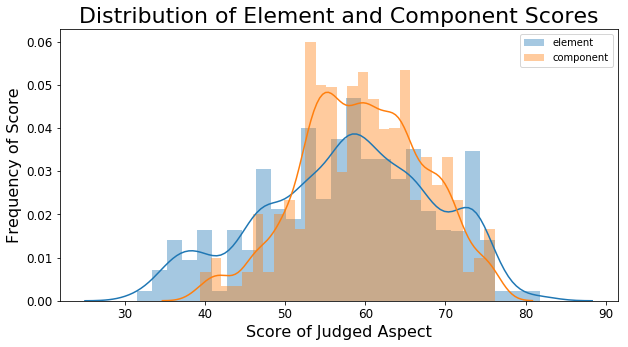

In [13]:
# show the distribution of component and element scores
plt.figure(figsize=(10, 5))
ax=sns.distplot(ladies['total_element_score'], label='element')
ax=sns.distplot(ladies['total_component_score'], label='component')
plt.title('Distribution of Element and Component Scores', fontsize=22)
plt.xlabel('Score of Judged Aspect', fontsize=16)
plt.ylabel('Frequency of Score', fontsize=16)
ax.legend()
plt.tick_params(axis='both', which='major', labelsize=12)

The distributions of the element and component scores are normal. The distribution of the GBM model should match the dsitribution of the response variable, so a gaussian distribution will be used. 

### Run model - neural network

For the first run, the standard hyperparamters will be used.

In [14]:
# import model
import h2o
h2o.init()
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
# create dataframe for H2O
df_run_model=h2o.H2OFrame(df_model)
# initiate
train,test,valid = df_run_model.split_frame(ratios=[0.7, 0.15])
NN = H2ODeepLearningEstimator(nfolds=5, epochs=1000, variable_importances=True)
NN.train(y='total_score', x=['base_value1', 'base_value2', 'base_value3', 'base_value4', 'base_value5', 
                             'base_value6', 'base_value7', 'base_value8', 'base_value9', 'base_value10',
                             'base_value11', 'base_value12', 'goe_actual1', 'goe_actual2', 'goe_actual3', 
                             'goe_actual4', 'goe_actual5', 'goe_actual6', 'goe_actual7', 'goe_actual8', 
                             'goe_actual9', 'goe_actual10', 'goe_actual11', 'goe_actual12', 'total_deductions'],
         training_frame=train, validation_frame=train)
# cross validation scores
cv_summary_nn = NN.cross_validation_metrics_summary().as_data_frame()
print(cv_summary_nn)
# run validation testing
print(NN.model_performance(valid=True))

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,25 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,11 months and 7 days !!!
H2O cluster name:,H2O_from_python_kyleknoebel_nerv7u
H2O cluster total nodes:,1
H2O cluster free memory:,1.594 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning Model Build progress: |██████████████████████████████████████| 100%
                                  mean           sd  cv_1_valid  cv_2_valid  \
0                     mae    4.2375774    0.5132939    4.719784   5.4105377   
1  mean_residual_deviance    27.751825    5.8022165   32.149334   41.685867   
2                     mse    27.751825    5.8022165   32.149334   41.685867   
3                      r2    0.6998775   0.02956384   0.6207655  0.72803867   
4       residual_deviance    27.751825    5.8022165   32.149334   41.685867   
5                    rmse     5.213799    0.5329744    5.670038    6.456459   
6                   rmsle  0.073170744  0.009316226  0.07888157  0.09622819   

   cv_3_valid  cv_4_valid  cv_5_valid  
0   3.7910051   3.4135406     3.85302  
1   24.283953   20.899202    19.74077  
2   24.283953   20.899202    19.74077  
3   0.7105261  0.70049757   0.7395596  
4   2

<Figure size 2500x1000 with 0 Axes>

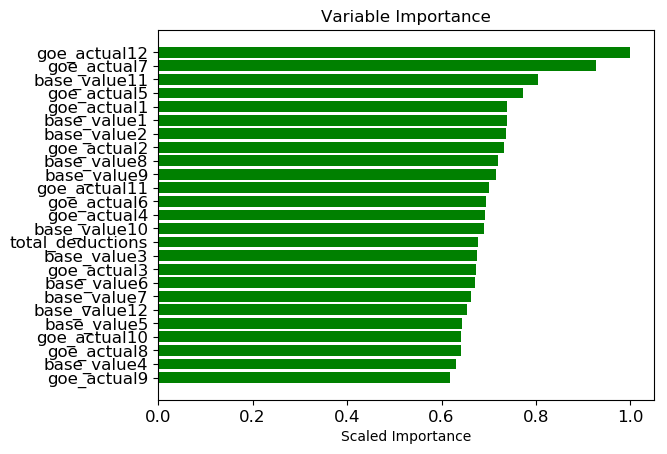

In [15]:
plt.rcdefaults()
plt.figure(figsize=(25, 10))
fig, ax = plt.subplots()
variables = NN._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = NN._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

The model above show high accuracy, but is very imbalanced. How can the model be changed to fix the overfitting?

Firstly, there are 25 features to analyze in the model, so the neural network will have 25 perceptrons. Also, we will use 4 layers here in order to help the corss valiation tests find convergence. 

In addition, a stopping metric and stratified cv testing parameters will be added becasue the prediction data is continuous. For the stratified sampling, this should fix any unnecessary variance arising from some scores only having one or very few samples. Lastly, the training data will be shiffled to improve cv testing.    

In [16]:
# initiate
train,test,valid = df_run_model.split_frame(ratios=[0.7, 0.15])
NN2 = H2ODeepLearningEstimator(nfolds=5, hidden=[25, 25, 25, 25], epochs=1000, distribution='gaussian', 
                              stopping_metric='deviance', score_validation_sampling='stratified', 
                              variable_importances=True, elastic_averaging=True, shuffle_training_data=True)
NN2.train(y='total_score', x=['base_value1', 'base_value2', 'base_value3', 'base_value4', 'base_value5', 
                             'base_value6', 'base_value7', 'base_value8', 'base_value9', 'base_value10',
                             'base_value11', 'base_value12', 'goe_actual1', 'goe_actual2', 'goe_actual3', 
                             'goe_actual4', 'goe_actual5', 'goe_actual6', 'goe_actual7', 'goe_actual8', 
                             'goe_actual9', 'goe_actual10', 'goe_actual11', 'goe_actual12', 'total_deductions'],
         training_frame=train, validation_frame=train)
# cross validation scores
cv_summary_nn2 = NN2.cross_validation_metrics_summary().as_data_frame()
print(cv_summary_nn2)
# run validation testing
print(NN2.model_performance(valid=True))

deeplearning Model Build progress: |██████████████████████████████████████| 100%
                                 mean           sd   cv_1_valid  cv_2_valid  \
0                     mae    4.174552   0.19858015    4.4347143   4.2294817   
1  mean_residual_deviance   28.497868    3.7318635     36.84267    30.57315   
2                     mse   28.497868    3.7318635     36.84267    30.57315   
3                      r2  0.63776267  0.019575976   0.62700313  0.67320585   
4       residual_deviance   28.497868    3.7318635     36.84267    30.57315   
5                    rmse   5.3152537   0.35067347    6.0698166   5.5292993   
6                   rmsle  0.07225565  0.005355847  0.080073684  0.07968586   

   cv_3_valid  cv_4_valid   cv_5_valid  
0    4.013847    4.475443    3.7192745  
1     26.1203   28.173336     20.77988  
2     26.1203   28.173336     20.77988  
3  0.63888144  0.65746564   0.59225726  
4     26.1203   28.173336     20.77988  
5    5.110802    5.307856    4.5584955  

<Figure size 2500x1000 with 0 Axes>

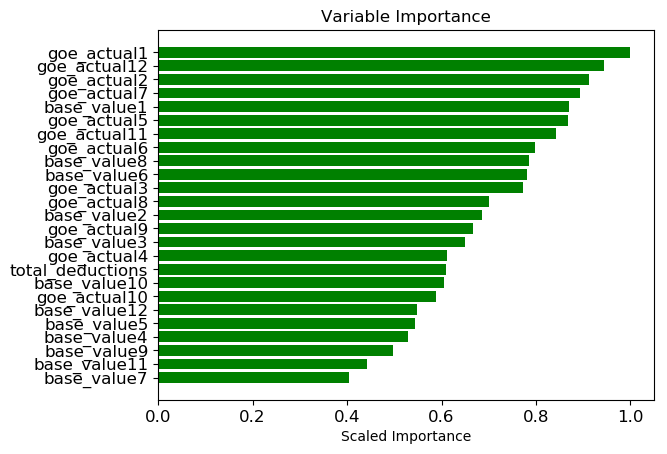

In [17]:
plt.rcdefaults()
plt.figure(figsize=(25, 10))
fig, ax = plt.subplots()
variables = NN2._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = NN2._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

With the parameter tuning, the cv scores improved, and the accuracy even improved minutely over the original. 

### Test on other data

The original data also include performances from the 2016 Olympics, data which was not included in this analysis. How does the model perform when predicitng the component scores of these performances?  

In [18]:
# import olympic performance data
path=r"/Users/kyleknoebel/Desktop/ThinkfulNotebooks/Unit 3 Capstone/performances_2018O.csv"
test_perf=pd.read_csv(path)
path2=r"/Users/kyleknoebel/Desktop/ThinkfulNotebooks/Unit 3 Capstone/judged-aspects_2018O.csv"
test_asp=pd.read_csv(path2)
test_perf['total_deductions']=test_perf['total_deductions'].astype(str)
test_perf['total_deductions']=test_perf['total_deductions'].str.replace('-', ' ')
test_perf['total_deductions']=test_perf['total_deductions'].astype(float)
# merge the dataframes
df_test=test_perf.merge(test_asp, how='left', on=['performance_id'])
# fill null values
df_test=df_test.fillna(0)
df_test.head()

,performance_id,competition,program,name,nation,rank,starting_number,total_segment_score,total_element_score,total_component_score,...,section,aspect_num,aspect_desc,info_flag,credit_flag,base_value,factor,goe,ref,scores_of_panel
0,a3f8fac157,Olympic Winter Games 2018,Ice Dance - Free Dance,LAURIAULT Marie-Jade / le GAC Romain,FRA,17,1,89.62,47.04,42.58,...,components,0.0,Interpretation of the Music/Timing,0,0,0.0,1.2,0.00,0.0,7.07
1,a3f8fac157,Olympic Winter Games 2018,Ice Dance - Free Dance,LAURIAULT Marie-Jade / le GAC Romain,FRA,17,1,89.62,47.04,42.58,...,elements,8.0,ChLi1,0,0,1.0,0.0,0.70,0.0,1.70
2,a3f8fac157,Olympic Winter Games 2018,Ice Dance - Free Dance,LAURIAULT Marie-Jade / le GAC Romain,FRA,17,1,89.62,47.04,42.58,...,components,0.0,Skating Skills,0,0,0.0,1.2,0.00,0.0,7.25
3,a3f8fac157,Olympic Winter Games 2018,Ice Dance - Free Dance,LAURIAULT Marie-Jade / le GAC Romain,FRA,17,1,89.62,47.04,42.58,...,elements,7.0,DiSt2,0,0,5.6,0.0,0.79,0.0,6.39
4,a3f8fac157,Olympic Winter Games 2018,Ice Dance - Free Dance,LAURIAULT Marie-Jade / le GAC Romain,FRA,17,1,89.62,47.04,42.58,...,elements,6.0,CuLi4,0,0,4.5,0.0,0.77,0.0,5.27


In [19]:
# clean data
# lower the capilization of the program and competition1 columns to standardize formatting
df_test.iloc[:, 2] = df_test.iloc[:, 2].str.lower()
df_test.iloc[:, 1] = df_test.iloc[:, 1].str.lower()
# clean the text for interpretations
df_test.iloc[:, 15]=df_test.iloc[:, 15].str.replace('Interpretation of the Music / Timing', 
                                                        'Interpretation of the Music')
df_test.iloc[:, 15]=df_test.iloc[:, 15].str.replace('Interpretation of the Music/Timing', 
                                                        'Interpretation of the Music')
# remove ice dancing from the dataset
df_test=df_test[~df_test['program'].str.contains('ice dance')]
#remove short program from the dataset
df_test=df_test[~df_test['program'].str.contains('short')]
# create separate dataframe for ladies competition
# find the rows that contain 'ladies' in the name of each program category in the data frame 
ladies_test=df_test[df_test.iloc[:, 2].str.contains('ladies' , regex=False, case=False, na=False)]

# create separate dataframes for components and elements
elems_test=ladies_test[ladies_test['section']=='elements']
compos_test=ladies_test[ladies_test['section']=='components']

# recategorize the object columns as category
compos_model_test=compos_test.copy()
compos_model_test = pd.concat([
        compos_test.select_dtypes([], ['object']),
        compos_test.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1).reindex(compos_test.columns, axis=1)
# create categorical values
objs_test=compos_model_test[['aspect_desc']]
compos_model_test=compos_model_test.drop(['aspect_desc'], 1)
objs_test= objs_test.apply(lambda x: x.cat.codes)
objs_test=objs_test.rename(columns={"aspect_desc": "aspect_cat"})
# drop string values and add categorical values
compos_model_test=pd.concat([compos_model_test, objs_test], 1)

# create a dataframe with only variables of interest and show format
df_model_test = elems_test.drop(['competition', 'program', 'name', 'nation', 'rank', 'starting_number', 
                         'total_segment_score', 'total_element_score', 'total_component_score', 'aspect_id',
                        'section', 'factor', 'aspect_num', 'aspect_desc', 'info_flag', 
                             'credit_flag', 'ref', 'scores_of_panel'], 1)
# create actual GOE value and remove old value
df_model_test['goe_actual']=df_model_test['goe']/df_model_test['base_value']
# add a rank column to rank the base values by performance id
df_model_test["rank"] = df_model_test.groupby("performance_id")["base_value"].rank("dense", ascending=False)
df_model_test=df_model_test.reset_index()
# sort the values by this ranking
df_model_test=df_model_test.sort_values('rank')
# create separate data frame for deductions
df_deduc_test=df_model_test.copy()
df_deduc_test=df_deduc_test.drop(['base_value', 'goe', 'goe_actual', 'rank'], 1)
# drop duplicate performances
df_deduc_test['performance_id']=df_deduc_test['performance_id'].drop_duplicates()
df_deduc_test=df_deduc_test.dropna()
# create a pivot table showing the base value, goe, and deductions for each performance
df_model_test=pd.pivot_table(df_model_test, index=['performance_id'], 
                             columns=df_model_test.groupby(['performance_id']).cumcount().add(1), 
                  values=['base_value','goe_actual', 'rank'], aggfunc='sum')
# relabel columns with proper titles
df_model_test.columns=df_model_test.columns.map('{0[0]}{0[1]}'.format) 
# reset index for modeling
df_model_test=df_model_test.reset_index()
# drop the ranks columns, they are not needed for model
df_model_test=df_model_test.drop(['rank1', 'rank2', 'rank3', 'rank4', 'rank5', 'rank6', 'rank7', 'rank8', 'rank9', 'rank10',
                       'rank11', 'rank12'], 1)
# add the deduction column 
df_model_test=df_model_test.merge(df_deduc_test, how='left', on=['performance_id'])
# create target table 
# only keep variables of interest for modeling
df_target_test=compos_model_test.drop(['competition', 'program', 'name', 'nation', 'rank', 'starting_number', 
                             'total_segment_score', 'total_element_score', 'total_deductions', 'aspect_id', 
                             'section', 'aspect_num', 'info_flag', 'credit_flag', 'base_value', 'factor', 'goe', 
                                 'ref', 'total_component_score'], 
                            1)
# create pivot table of values
df_target_test=pd.pivot_table(df_target_test, index=["performance_id"], columns=['aspect_cat'],
                         values=(['scores_of_panel']), aggfunc='sum')
# add mean column to target table
df_target_test['total_score']=df_target_test.sum(axis=1)
# add the factor into component score
df_target_test['total_score']=df_target_test['total_score']*2
# reset index
df_target_test=df_target_test.reindex()
# add the mean score column from the target table to the model table
df_model_test=df_model_test.merge(df_target_test['total_score'], how='left', on=['performance_id'])
df_model_test.head()


,performance_id,base_value1,base_value2,base_value3,base_value4,base_value5,base_value6,base_value7,base_value8,base_value9,...,goe_actual6,goe_actual7,goe_actual8,goe_actual9,goe_actual10,goe_actual11,goe_actual12,index,total_deductions,total_score
0,187be2a42e,9.60,9.57,6.49,6.0,5.83,5.61,3.9,3.63,3.5,...,0.303030,0.512821,0.195592,0.325714,0.305714,0.422222,0.900000,911,0.0,96.84
1,18d403622f,8.60,6.90,6.40,6.0,3.63,3.50,3.3,2.30,2.0,...,0.142857,0.281818,-0.091304,0.450000,0.226316,0.000000,-0.054545,649,1.0,70.58
2,1ba3d7fa7d,10.30,9.02,6.93,5.3,4.84,4.62,3.9,3.50,3.5,...,-0.432900,0.282051,0.285714,0.285714,0.260606,0.370370,0.450000,758,0.0,78.66
3,2178d0174d,7.48,6.60,6.27,6.0,5.10,4.73,3.9,3.50,3.2,...,0.042283,0.512821,0.142857,0.221875,0.333333,-0.197628,0.900000,2839,0.0,92.84
4,2f7f38af84,10.30,10.01,8.36,5.3,5.10,4.84,3.9,3.63,3.5,...,0.165289,0.384615,0.157025,0.245714,0.290625,0.555556,0.850000,836,0.0,89.06


**Note:** In Olympic judging, deductions are give a [negative value](https://www.bustle.com/p/how-do-figure-skating-judges-score-performances-at-the-winter-olympics-things-get-complicated-8120361).

In [20]:
# create test H2O frame and get prediction scores
# convert pandas dataframe to h2o dataframe
df_run_test=h2o.H2OFrame(df_model_test)
# get prediction score
preds=NN.predict(test_data=df_run_test)
preds=preds.as_data_frame()
df_pred = pd.DataFrame({'Component Scores':df_model_test['total_score'],'Predicted':preds['predict']})
# run validation testing
print(df_pred)

print('The correlation between the score sets is {}%.'.format(df_pred['Component Scores'].corr(df_pred['Predicted'])))

/Users/kyleknoebel/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%
    Component Scores  Predicted
0              96.84  95.135616
1              70.58  71.322353
2              78.66  83.225397
3              92.84  83.887980
4              89.06  88.900496
5              67.92  73.358603
6              62.58  71.577786
7              94.56  92.627540
8              83.00  77.163535
9              93.78  88.943428
10             77.20  66.819384
11             85.14  78.569037
12             69.98  76.356165
13             63.80  57.628717
14             84.14  75.953887
15             93.78  89.356594
16             80.20  73.536291
17             73.50  68.793805
18             63.00  68.276602
19             85.34  85.127787
20             67.44  67.945198
21             77.56  76.723495
22             64.26  67.066726
23             94.56  81.448706
24             65.16  66.002189
25    